In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import cv2
import dlib
import os
import keras
import sklearn

In [2]:
import tensorflow as tf
from os import listdir
from os.path import isfile, join

In [3]:
pose68 = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
pose05 = dlib.shape_predictor('models/shape_predictor_5_face_landmarks.dat')

def face_landmarks(face, model="large"):
    
    if model == "large":
        predictor = pose68
    elif model == "small":
        predictor = pose05
    
    if not isinstance(face, list):
        rect = dlib.rectangle(0,0,face.shape[1],face.shape[0])
        return predictor(face, rect)
    else:
        rect = dlib.rectangle(0,0,face[0].shape[1],face[0].shape[0])
        return [predictor(f,rect) for f in face]

In [4]:
hog_detector = dlib.get_frontal_face_detector()
cnn_detector = dlib.cnn_face_detection_model_v1('models/mmod_human_face_detector.dat')

def face_locations(image, model="hog"):
    
    if model == "hog":
        detector = hog_detector
        cst = 0
    elif model == "cnn":
        detector = cnn_detector
        cst = 10
            
    matches = detector(image,1)
    rects   = []
    
    for r in matches:
        if model == "cnn":
            r = r.rect
        x = max(r.left(), 0)
        y = max(r.top(), 0)
        w = min(r.right(), image.shape[1]) - x + cst
        h = min(r.bottom(), image.shape[0]) - y + cst
        rects.append((x,y,w,h))
        
    return rects

In [7]:
faceSet = []
faceSetName = []
pathF = "./mergeFace/"
imagePaths = [f for f in listdir(pathF) if isfile(join(pathF, f))]


for img in imagePaths:
    
    im = cv2.imread(pathF+img)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    rect = dlib.rectangle(0,0,128,128)
    landmarks = pose68(gray, rect)
    faceSet.append(dlib_Point_to_Numpy_Array(landmarks))
    faceSetName.append(os.path.splitext(img)[0])

In [6]:
def dlib_Point_to_Numpy_Array(dlibCoord):

    numpyCoord = np.zeros((68, 2))

    for i in range(0, 68):
        numpyCoord[i] = (dlibCoord.part(i).x, dlibCoord.part(i).y)
        
    return numpyCoord

Thomas_BLUSSON


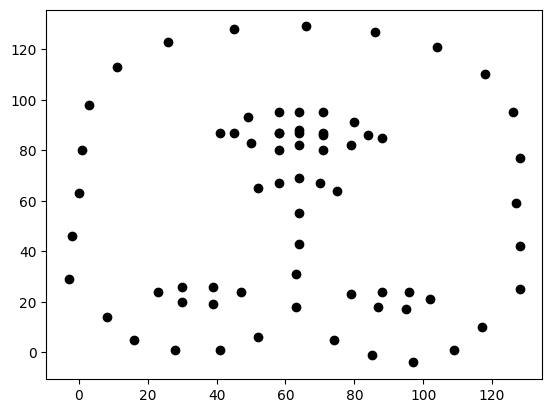

In [10]:

plt.plot(np.transpose(faceSet[10])[0],np.transpose(faceSet[10])[1], 'o', color='black')
print(faceSetName[10])

In [11]:
def image_comp(img1):
    img1 = dlib_Point_to_Numpy_Array(img1)
    value = []
    for img2 in faceSet :
        value.append((np.transpose(img1)-(np.transpose(img2).mean())))
    return faceSetName[np.argmin(value)]

In [138]:
def process_frame(image, mode="fast"):
    
    # face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if mode == "fast":
        matches = hog_detector(gray,1)
    else:
        matches = cnn_detector(gray,1)
        matches = [m.rect for m in matches]
        
    for rect in matches:
  
        # face landmarks
        landmarks = pose68(gray, rect)
        #print(landmarks.parts())
        # face encoding
        encoding = cnn_encoder.compute_face_descriptor(image, landmarks)
        
        # face classification
        #image_comp(landmarks.parts())
        label = image_comp(landmarks)
        #pres = pose68(image[rect.top():rect.bottom(),rect.left():rect.right()],)
        #print(pres)
        # draw box
        cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
        y = rect.top() - 15 if rect.top() - 15 > 15 else rect.bottom() + 25
        cv2.putText(image, label, (rect.left(), y), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
        
    return image

In [107]:
def process_movie(video_name, mode="fast"):
    
    video  = cv2.VideoCapture(video_name)
    
    try:
        
        while True:

            # Grab a single frame of video
            ret, frame = video.read()
            
            # Resize frame of video for faster processing
            frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)

            # Quit when the input video file ends or key "Q" is pressed
            key = cv2.waitKey(1) & 0xFF
            if not ret or key == ord("q"):
                break

            # Process frame
            image = process_frame(frame, mode)

            # Display the resulting image
            cv2.imshow('Video', image)
    
    finally:
        video.release()
        cv2.destroyAllWindows()
        print("Video released")

In [ ]:
process_movie(0)

In [ ]:
process_movie(0)

tf.image.ssim(im1, im2, max_val=1.0)